# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

In this project we analyzed data from the Basketball Reference Database, in order to determine the correlation between basketball players’ injuries (along with surgery) and the Average Field Goal and Free Throw percentages before and after their surgeries. The data we analyzed included the time frame of 2010-2020. The players in our data set were picked out so that they each had a specific injury along with the fact that they had stats for the season before and after their injury. We also made it so that the players’ specifically needed to have injuries that would have the option for surgery. We hypothesized that players who underwent surgery due to their specific injury would have a decrease in both AFG and AFT percentages. We used regressions along with t-tests in order to answer our question. In the end we figured out that players with specific injuries like hand and shoulder, who choose surgery tended to decrease in performance.

# Names

- Mani Amani
- Jorge Castaneda
- David Lopez
- Francesco Medina

<a id='research_question'></a>
# Research Question

How does treatment method (invasive or noninvasive) in bone fracture injuries correlate to game performance before and after treatment in NBA players?

<a id='background'></a>

## Background & Prior Work

Various studies have aimed to determine what specific body injuries are most common among NBA players. While attempting to discover the most common body injuries in the NBA, factors like age, height, weight, and player history have been consistently analyzed. Lateral ankle sprains were found to be the most frequent orthopaedic injury, followed by patellofemoral inflammation, lumbar strains, and hamstring strains. Patellofemoral inflammation injuries were often associated with most games missed; followed by lateral ankle sprains, knee sprains, and lumbar strains (Drakos, 2010). Player demographics were found not to be associated with player injury rates. Further studies have also come to consider gender when analyzing injury rates among basketball athletes in both NBA and WNBA. Female athletes had a higher overall game-related injury rate (Deitch, 2006). In addition to considering player background, injury rate, and most common type of injuries, factors like team performance during and after player leave of absence have also been explored (Facchetti, 2018).
Additional research has been done to analyze athlete performance before and after physical injuries. Yet the need to consider whether those players have gotten treatment and whether the form of treatment affects their performance is crucial to understanding the impact and effectiveness of getting certain treatments. More research is needed to fully understand how injury and treatment type affect player performance among NBA players.

References (include links):
- 1) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3445097/
- 2) https://www.academia.edu/37967247/The_Impact_of_NBA_Stars_Injuries_on_the_Performance_of_the_Teams
- 3) http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.859.62&rep=rep1&type=pdf

# Hypothesis


We believe that NBA players who undergo invasive treatment have a harder time performing after recovering from the injury compared to players who undergo non-invasive treatment. 

# Dataset(s)

- Dataset Name: Basketball Stats
- Link to the dataset: https://www.basketball-reference.com/
- Number of observations: 700

This dataset will contain the statistics of individual NBA players across years for different seasons from this website. We plan on webscraping the data for this dataset for the players we are interested in from the Kaggle dataset.


- Dataset Name: NBA Injuries from 2010-2020
- Link to the dataset: https://www.kaggle.com/ghopkins/nba-injuries-2010-2018?select=injuries_2010-2020.csv
- Number of observations: 27000

This dataset contains the details of every injury that NBA players had from the years 2010 to 2020.


We plan on combining the datasets by combining the player's statistics before and after the year of injury for each player on the Kaggle dataset.

# Setup

In [1]:
import pandas as pd
import numpy as np
import functions as fn
import seaborn as sns
import matplotlib.pyplot as plt # Typical way of import MPL
import matplotlib as mpl # This line is used less frequently
%config InlineBackend.figure_format ='retina'

# Statmodels & patsy
import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import skewnorm

df = pd.read_csv('injuries_2010-2020.csv')

# Data Cleaning

Starting with the injury dataset, we renamed the columns to make the data more readable. We then filtered out injuries that included 'broken' or 'fracture' in the string. The 'Acquired' column was dropped as it is not needed for our research question. A new column named 'Surgery' was added to indicate if the injury received surgery or not. The columns were then standardized to clean the data easier as well as make webscraping easier. Injuries occurring during the offseason and after the 2018-2019 season were dropped as we want to look at players that were injured during the NBA seasons in the range of 2010-2011 to 2018-2019. Any duplicate injury records for players were then removed and the first entry of the same injury was kept. We also removed duplicates where the same injury actually had surgery shortly after. Looking at the dataset we also removed injury records that indicated the player was still recovering from an injury happening from last season.

In [2]:
## Clean up Injury dataset ##
# Rename columns
k = df
k.rename(columns={"Date": "Season", "Relinquished": "Name", "Notes": "Injury"}, inplace=True)
# Filter injuries with 'fracture' and 'broken'
k = k[k['Injury'].str.contains('fracture') | k['Injury'].str.contains('broken')]
# Drop unneccessary column
k = k.drop(columns=['Acquired'])

# Make new column to indicate if there was surgery
k['Surgery'] = ['Y' if 'surgery' in x else 'N' for x in k['Injury']]

# Standardize columns
k['Injury'] = k['Injury'].apply(fn.standardize_injury)
k['Season'] = k['Season'].apply(fn.standardize_season)
k['Name'] = k['Name'].apply(fn.standardize_name)

# Drop injuries during offseason and after 2018-2019 season
k = k[k.Season != 'offseason']
# Drop any duplicates and keep first record of the same injury
k.drop_duplicates(subset=['Season', 'Name', 'Injury', 'Surgery'], keep='first', inplace=True)
# Drop duplicates where the injuries had surgery shortly after
k = k[~k.duplicated(['Season', 'Name', 'Injury'], keep=False) | k['Surgery'].eq('Y')]

# Reset indices
k.reset_index(drop=True, inplace=True)
# Drop rows that indicate they are still recovering from an injury from last season
k.drop({k.index[67], k.index[195], k.index[139], k.index[27]}, inplace=True)
# Reset indices again
k.reset_index(drop=True, inplace=True)

After cleaning the injury dataset, the next step is webscraping the player stats and saving the output to a dataframe. Any players with missing stat pages or didn't play a season before and after the injury are skipped.

In [3]:
## Retrieve player stats ##
k2 = fn.getData(k)

0) Mike Miller - https://www.basketball-reference.com/players/m/millemi01.html
1) Dominic McGuire - https://www.basketball-reference.com/players/m/mcguido01.html
	Next year not found or more than one team a year
2) Carlos Boozer - https://www.basketball-reference.com/players/b/boozeca01.html
3) Rodrigue Beaubois - https://www.basketball-reference.com/players/b/beaubro01.html
4) URL not found
5) Lou Amundson - https://www.basketball-reference.com/players/a/amundlo01.html
6) James Anderson - https://www.basketball-reference.com/players/a/anderja01.html
	Next year not found or more than one team a year
7) Greg Oden - https://www.basketball-reference.com/players/o/odengr01.html
	Next year not found or more than one team a year
8) Juwan Howard - https://www.basketball-reference.com/players/h/howarju01.html
9) Chauncey Billups - https://www.basketball-reference.com/players/b/billuch01.html
10) Delonte West - https://www.basketball-reference.com/players/w/westde01.html
11) Reggie Evans - http

The webscraped dataframe is then saved to a csv file.

In [4]:
# Write player stats dataframe to csv file
k2.to_csv('player_stats.csv', index=False)

The datasets are ready to be merged together. Rows with missing values are dropped and the indices are reset.

In [5]:
# Read player stats csv file and merge datasets
k2 = pd.read_csv('player_stats.csv')
k3 = k.join(k2)
# Drop rows with missing values meaning they didn't play a year before or after their injury
k3.dropna(inplace=True)
# Reset indices
k3.reset_index(drop=True, inplace=True)

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [6]:
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7) #default plot size to output

In [7]:
# increase the font size & remove background
# set this for all plots
sns.set(font_scale=2.5, style="white")

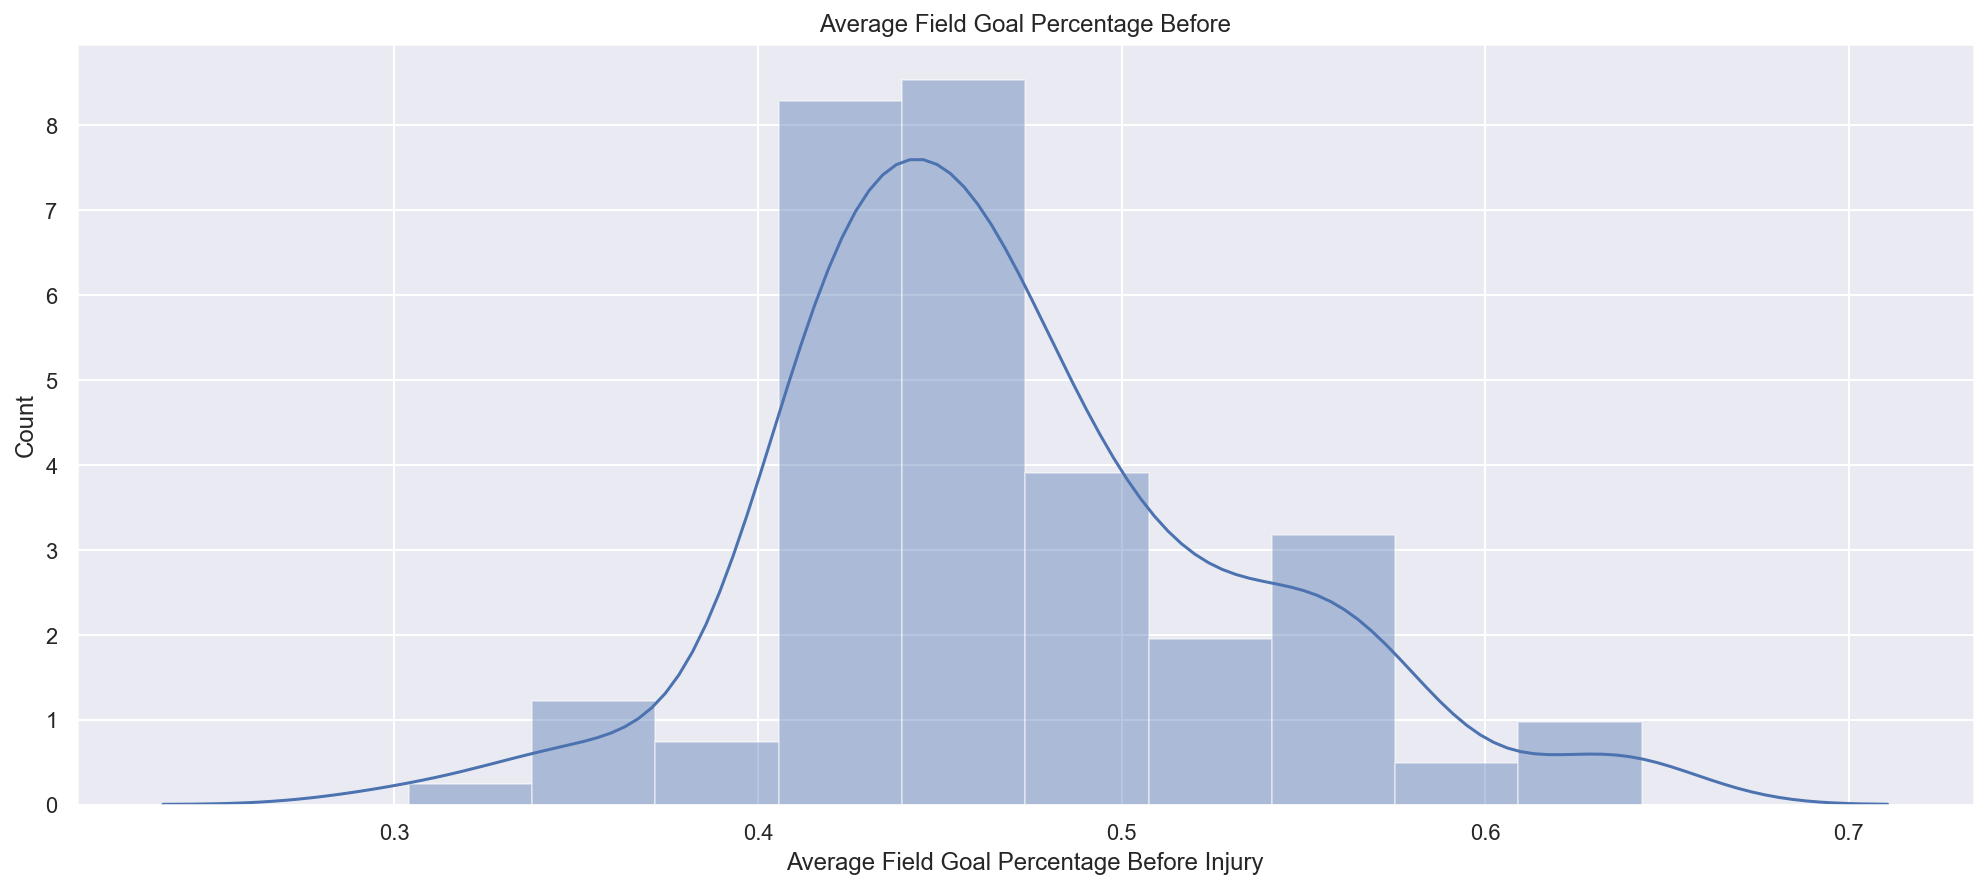

In [8]:
sns.set()
ax = sns.distplot(k3['FG%B'],bins = 10, kde = True)
# add title and axis labels (modify x-axis label)
ax.set_title('Average Field Goal Percentage Before');
ax.set_ylabel('Count');
ax.set_xlabel('Average Field Goal Percentage Before Injury');

This graph shows the average field goal percentage count before injury. We see that the mean is about .45. The total count of the mean is about 7 which tells us that before injuries players were scoring average field goals. The distribution seems normal (Gaussian).

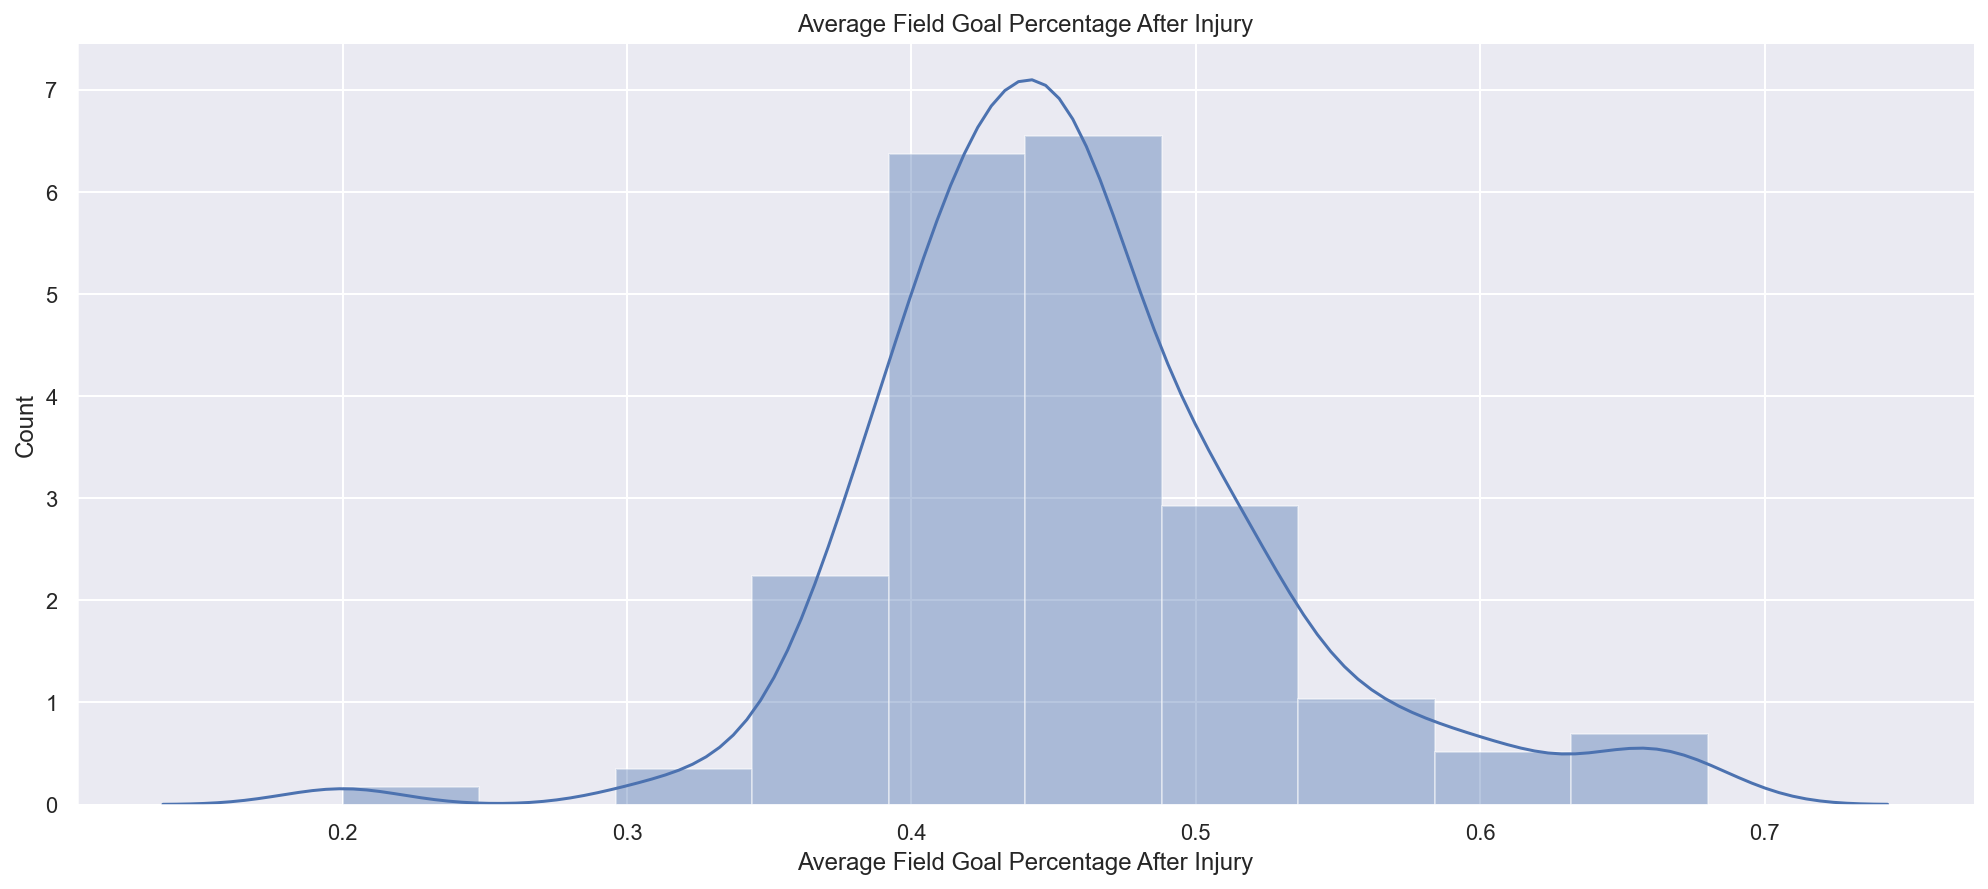

In [9]:
sns.set()
ax = sns.distplot(k3['FG%A'],bins = 10, kde = True)

# remove the top and right lines
sns.despine()

ax.set_title('Average Field Goal Percentage After Injury');
ax.set_ylabel('Count');
ax.set_xlabel('Average Field Goal Percentage After Injury');

This graph shows us the average field goal percentage count after injury. Much like the graph for avergae before injuries, this graph has a normal (Gaussian) distribution. Most of the data points seems to be centered. It's important to have these two graphs because it allows for an easy visual of the variables we are focusing on. Compared to the previous graph, we see that the mean has shifted slightly to the right, meaning that there was an increase in average field goal percentage.

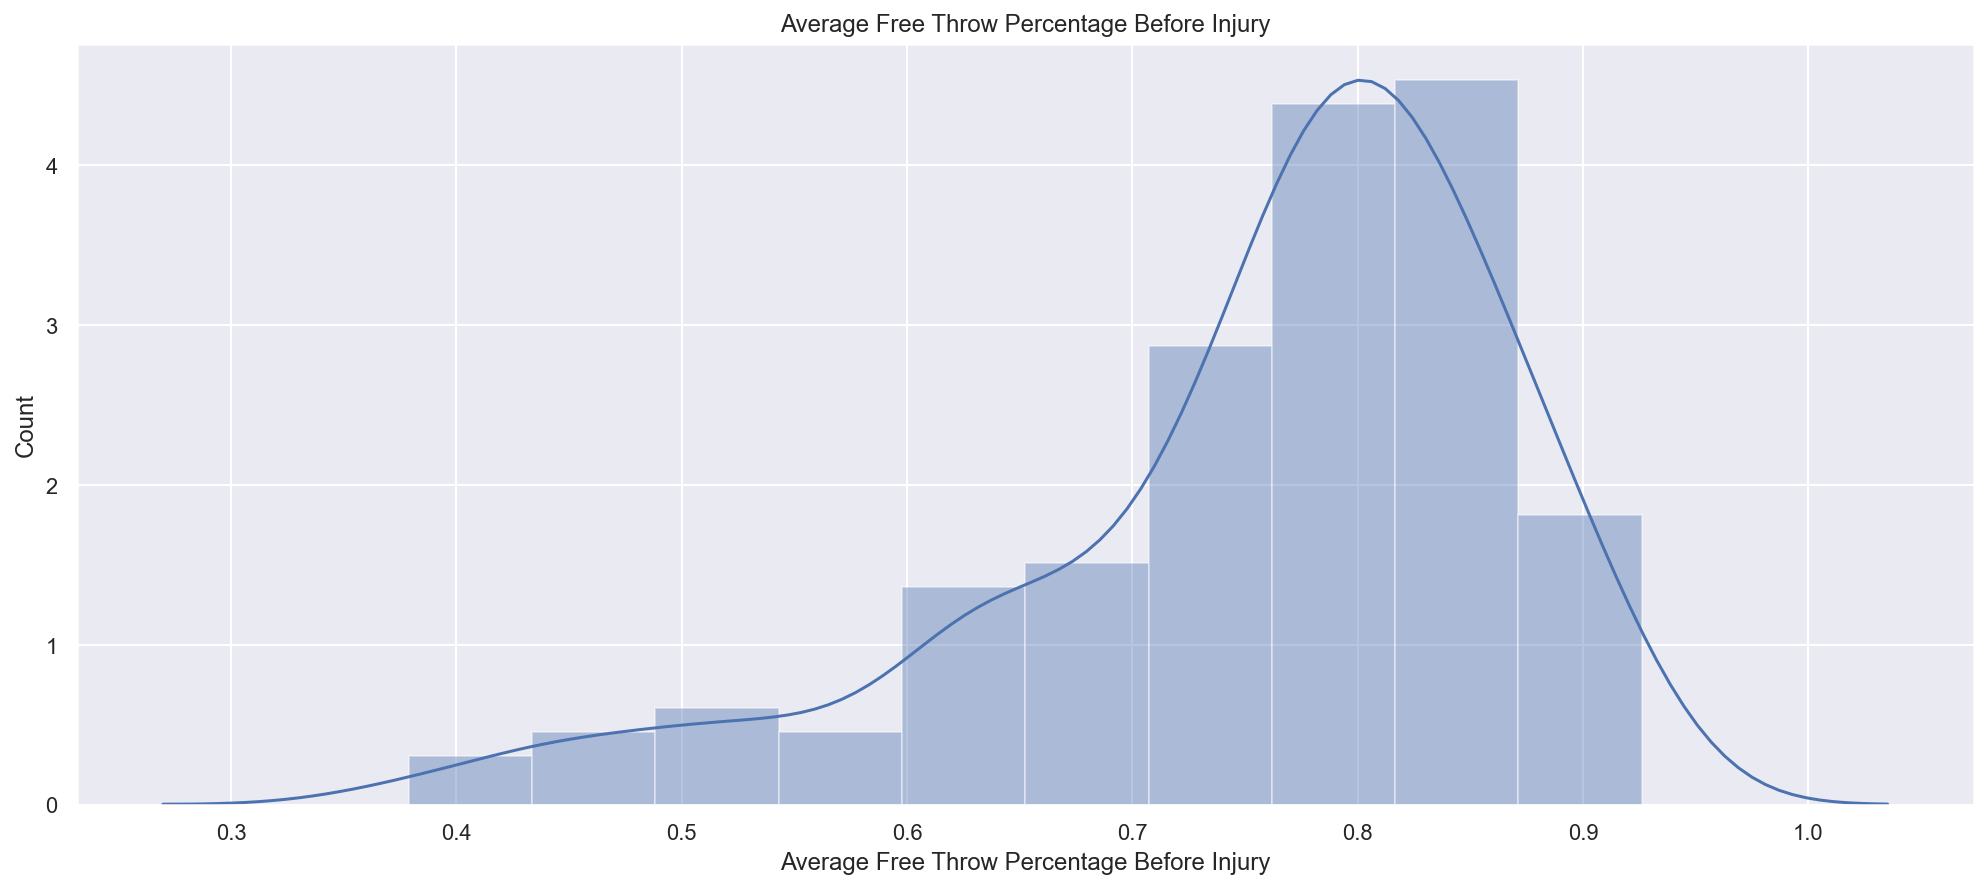

In [10]:
sns.set()
ax = sns.distplot(k3['FT%B'],bins = 10, kde = True)
ax.set_title('Average Free Throw Percentage Before Injury');
ax.set_ylabel('Count');
ax.set_xlabel('Average Free Throw Percentage Before Injury');

The following graph illustrates the average free throw percentage count before injury. Right away we can see that the graph is skewed left. Meaning that most of the data is on the right. This can be easily explained by the fact that free throws tend to have a high success rate. Meaning that an individual player is likely to make it with high probability. 

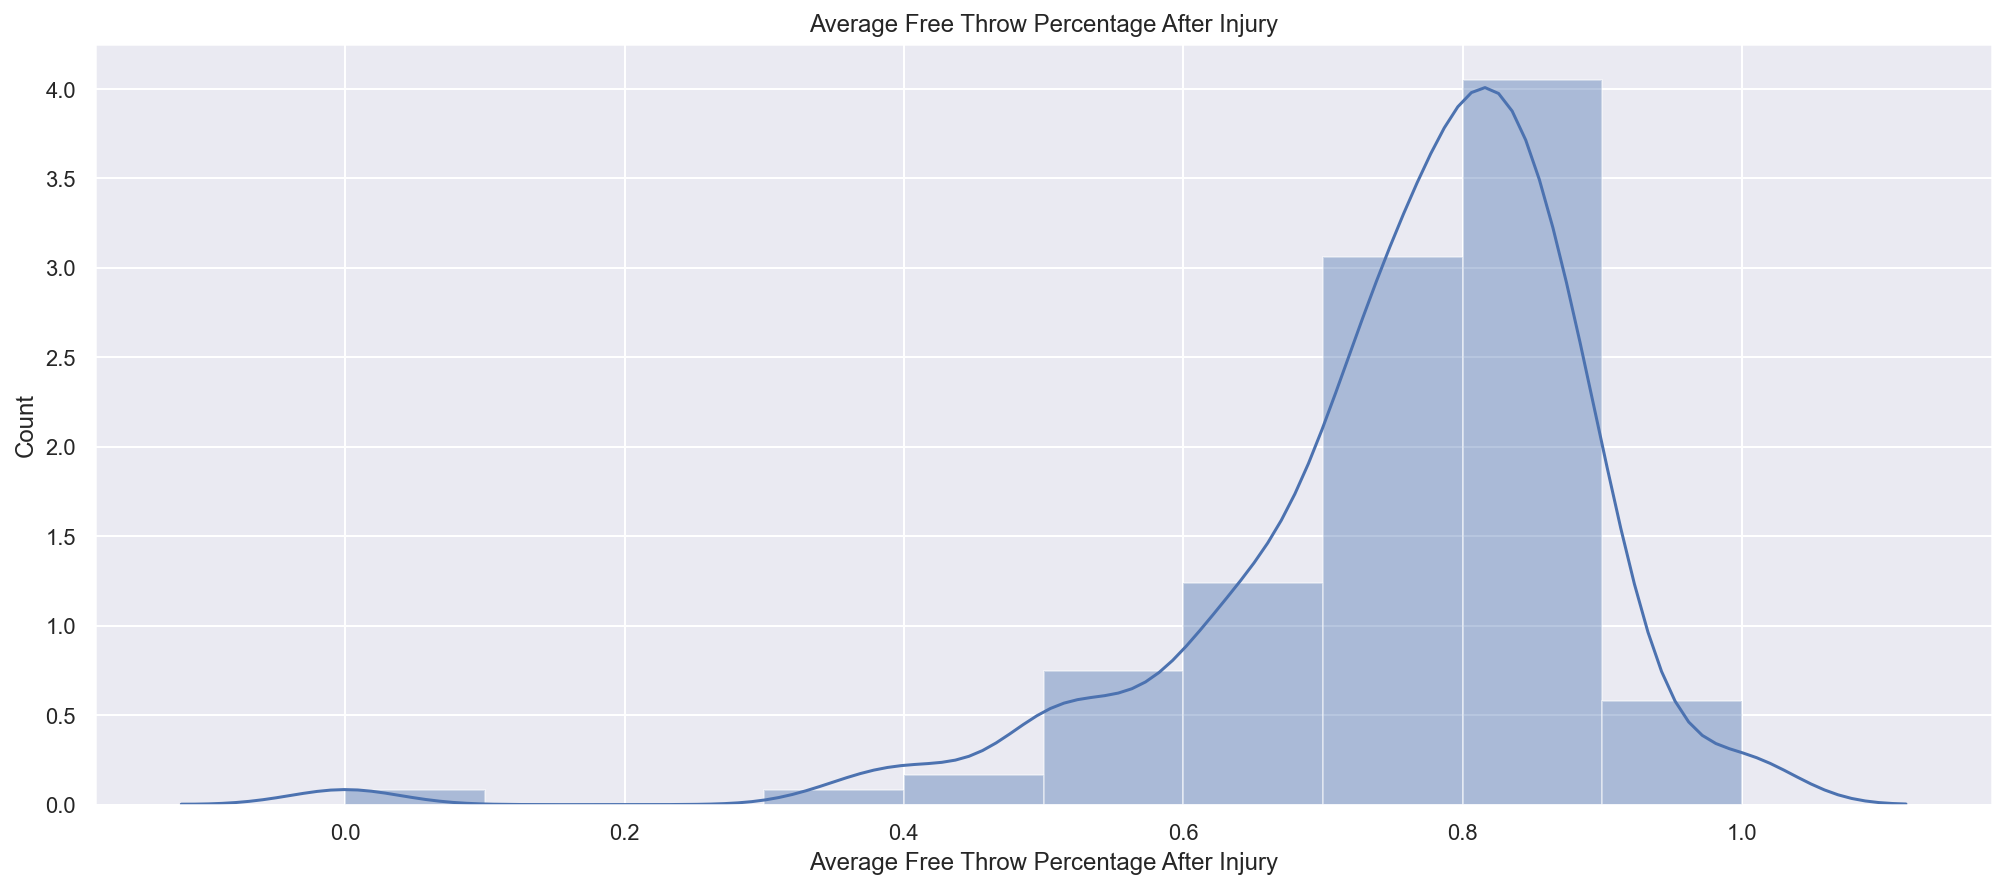

In [11]:
sns.set()
ax = sns.distplot(k3['FT%A'],bins = 10, kde = True)
ax.set_title('Average Free Throw Percentage After Injury');
ax.set_ylabel('Count');
ax.set_xlabel('Average Free Throw Percentage After Injury');

The following graph shows the average free throw percentage count after injury. Much like the previous graph the data is skewed left. Similar explanation to the previous one, free throws tend to have high success rate. The average increased also, as we can see that the graph shifted to the right. It's important to have these graphs because it allows for an easy interpretation of the variables we are working with. 

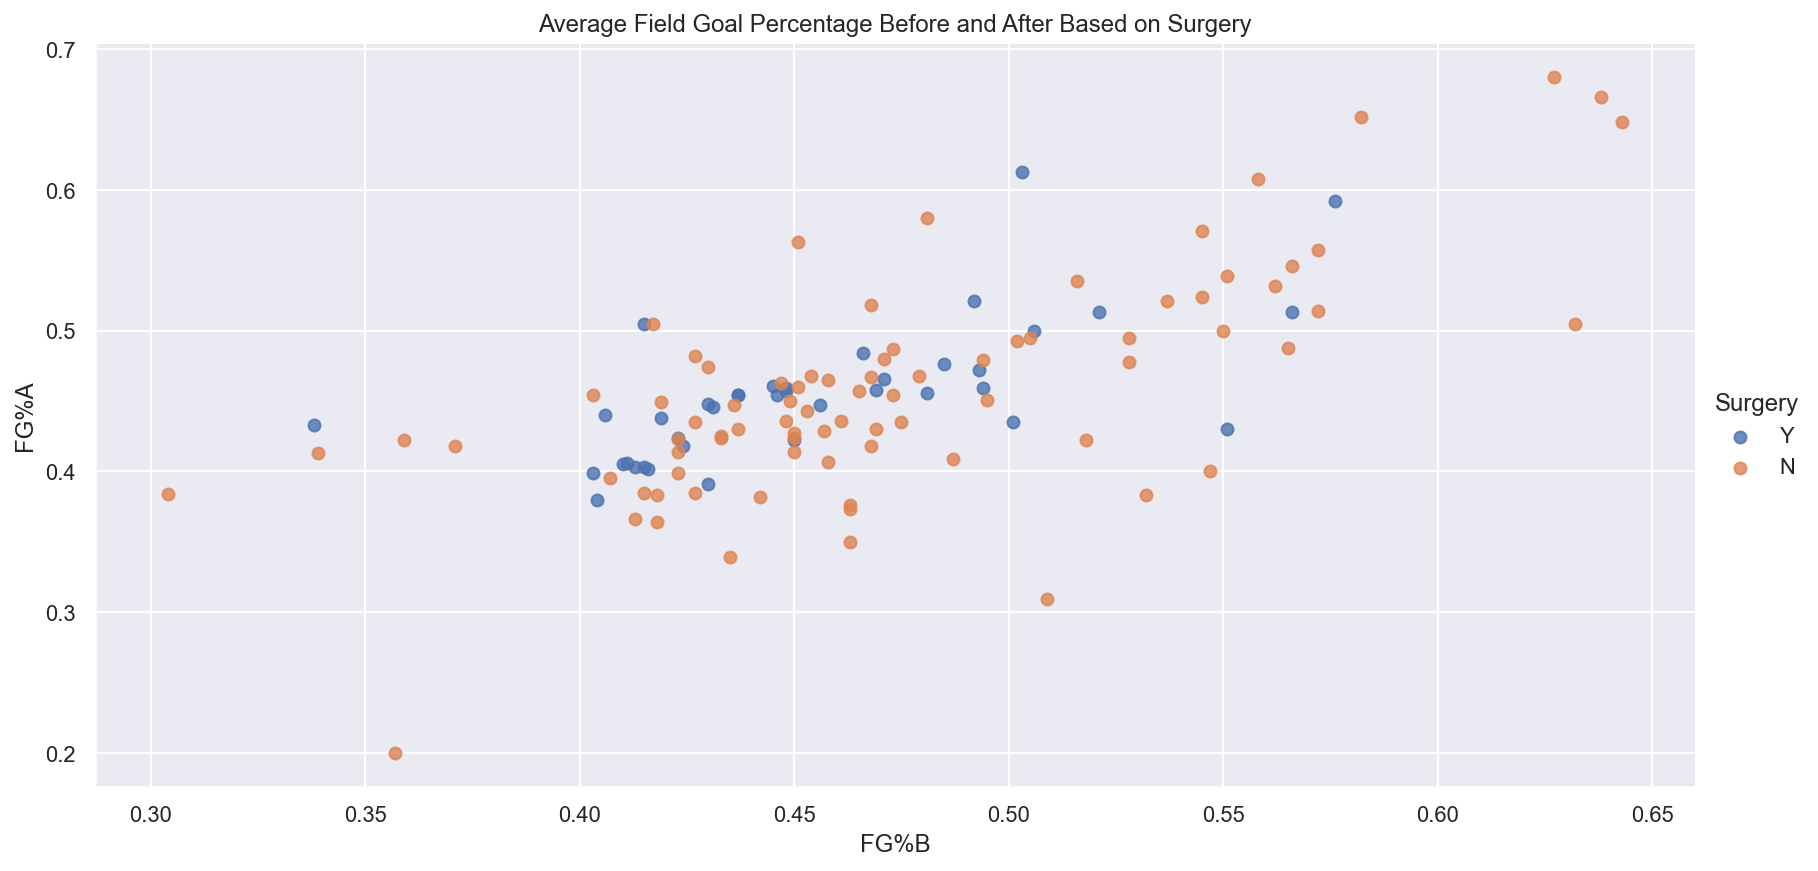

In [12]:
unique = k3['Injury'].append(k3['Surgery']).unique()
palette = dict(zip(unique, sns.color_palette()))
palette.update({'Total':'k'})

ax = sns.lmplot(x = 'FG%B', y = 'FG%A', data = k3, hue = 'Surgery',
           fit_reg = False, height = 6, aspect = 2)
ax = plt.gca()
ax.set_title('Average Field Goal Percentage Before and After Based on Surgery');

The following graph illustrated the average field goal percentage before and after based on whether the player had surgery or not. This allows for an interesting visual as we can see that most of the players who didn't have surgery tended to have higher average scores. The outliers are included because it allows for interpretation of success without surgery. Most of the points are correlated in the center.

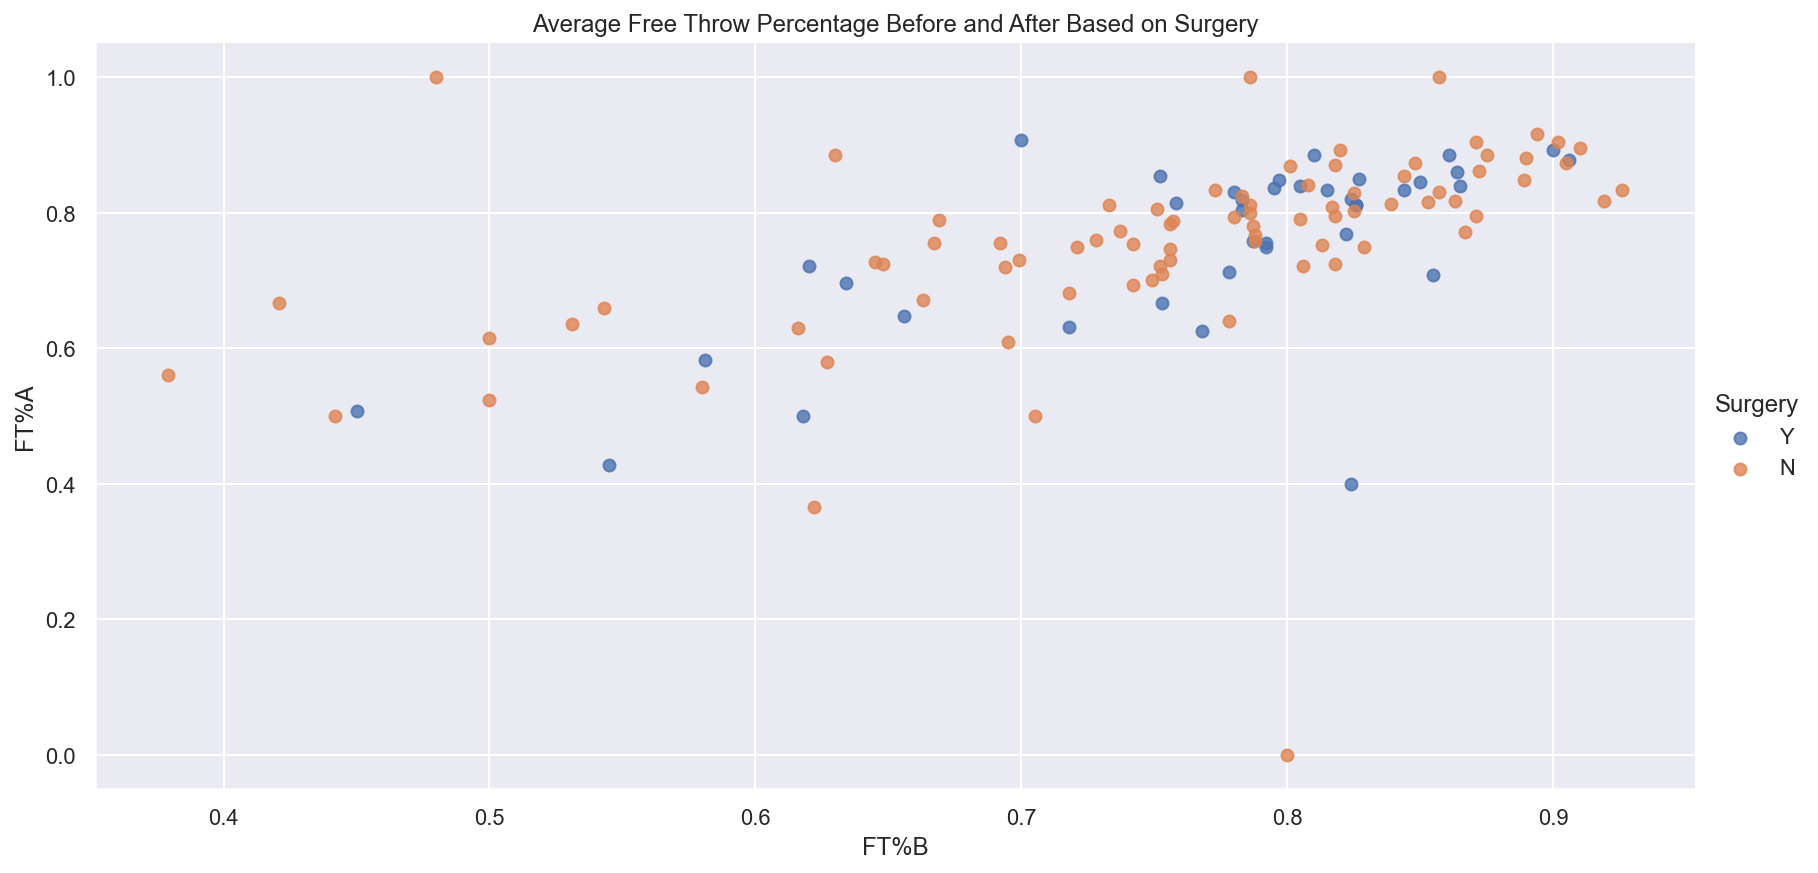

In [13]:
unique = k3['Injury'].append(k3['Surgery']).unique()
palette = dict(zip(unique, sns.color_palette()))
palette.update({'Total':'k'})

sns.lmplot(x = 'FT%B', y = 'FT%A', data = k3, hue = 'Surgery',
           fit_reg = False, height = 6, aspect = 2)
ax = plt.gca()
ax.set_title('Average Free Throw Percentage Before and After Based on Surgery');

The following graph illustrates the average free throw percentage before and after surgery based on whether the players had surgery or not. We can see that overall whether or not the players had surgery their average increased. There are some outliers that we choose to include because it shows consistency. 

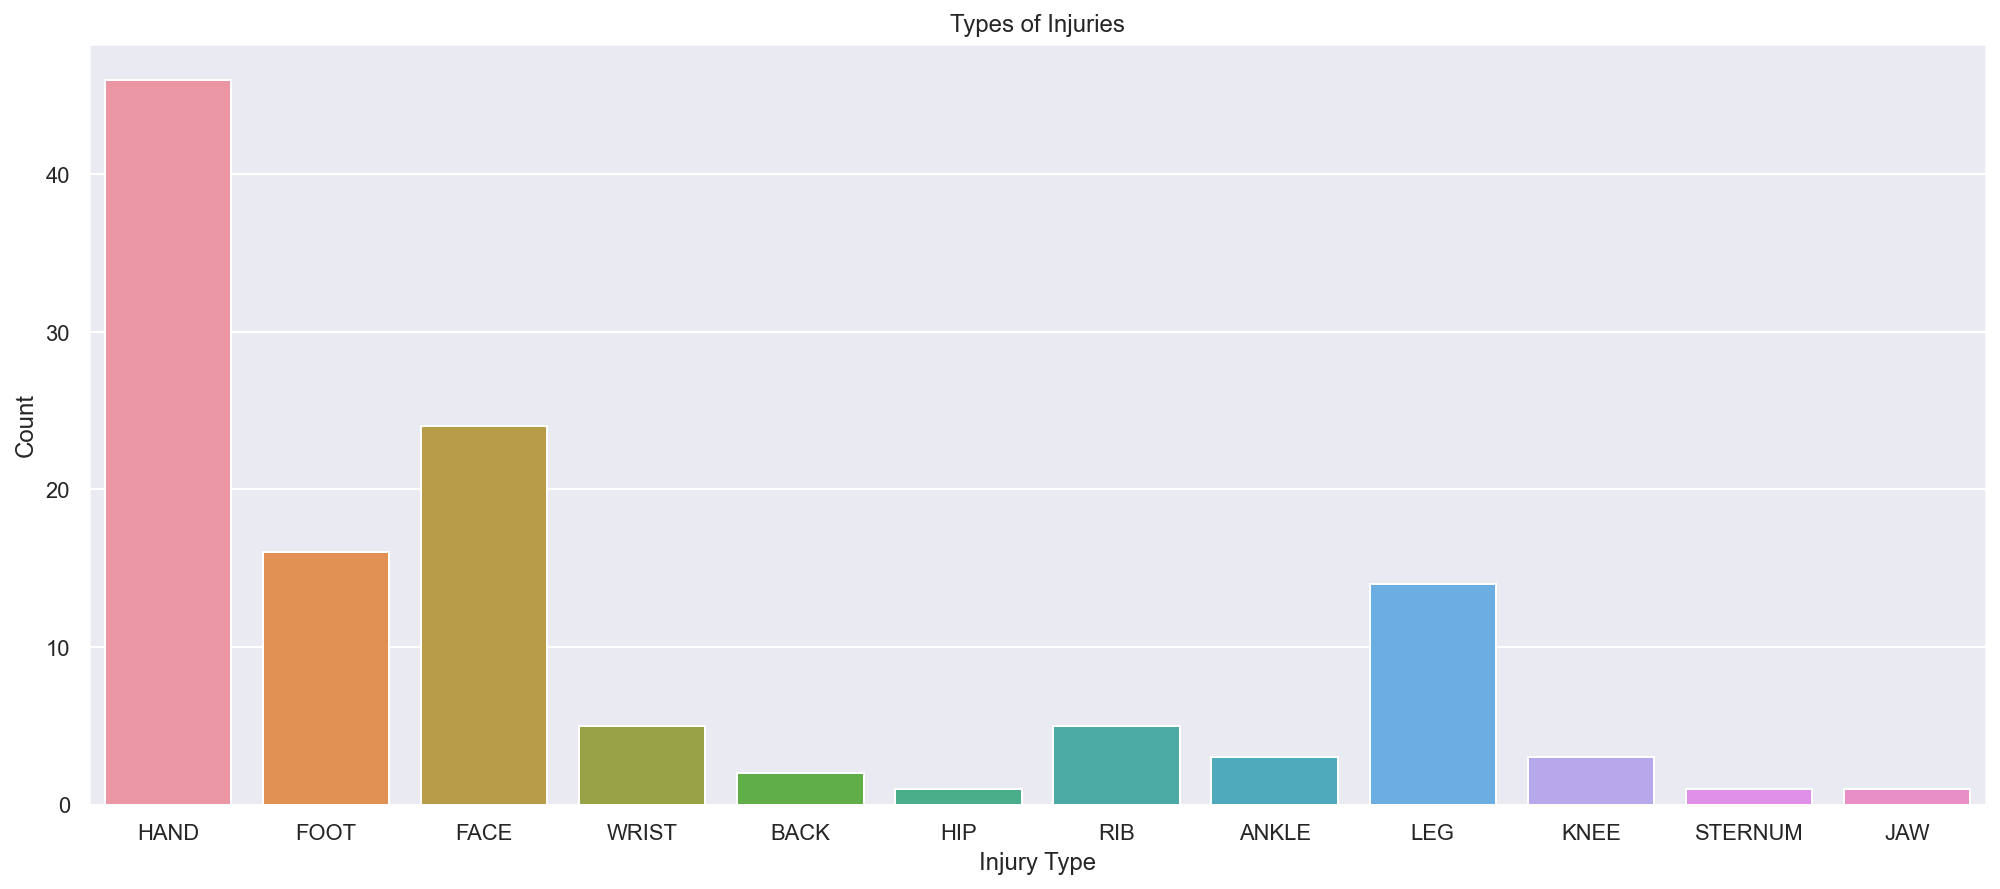

In [14]:
ax = sns.countplot(x = 'Injury', data = k3)
ax.set_title('Types of Injuries');
ax.set_ylabel('Count');
ax.set_xlabel('Injury Type');

This bar chart shows us the total count of the different types of injuries. We choose to include this graph because it allows for an easy visual for the different types of injuries. We can see that the most common injury was hand and hip injuries being the least common.

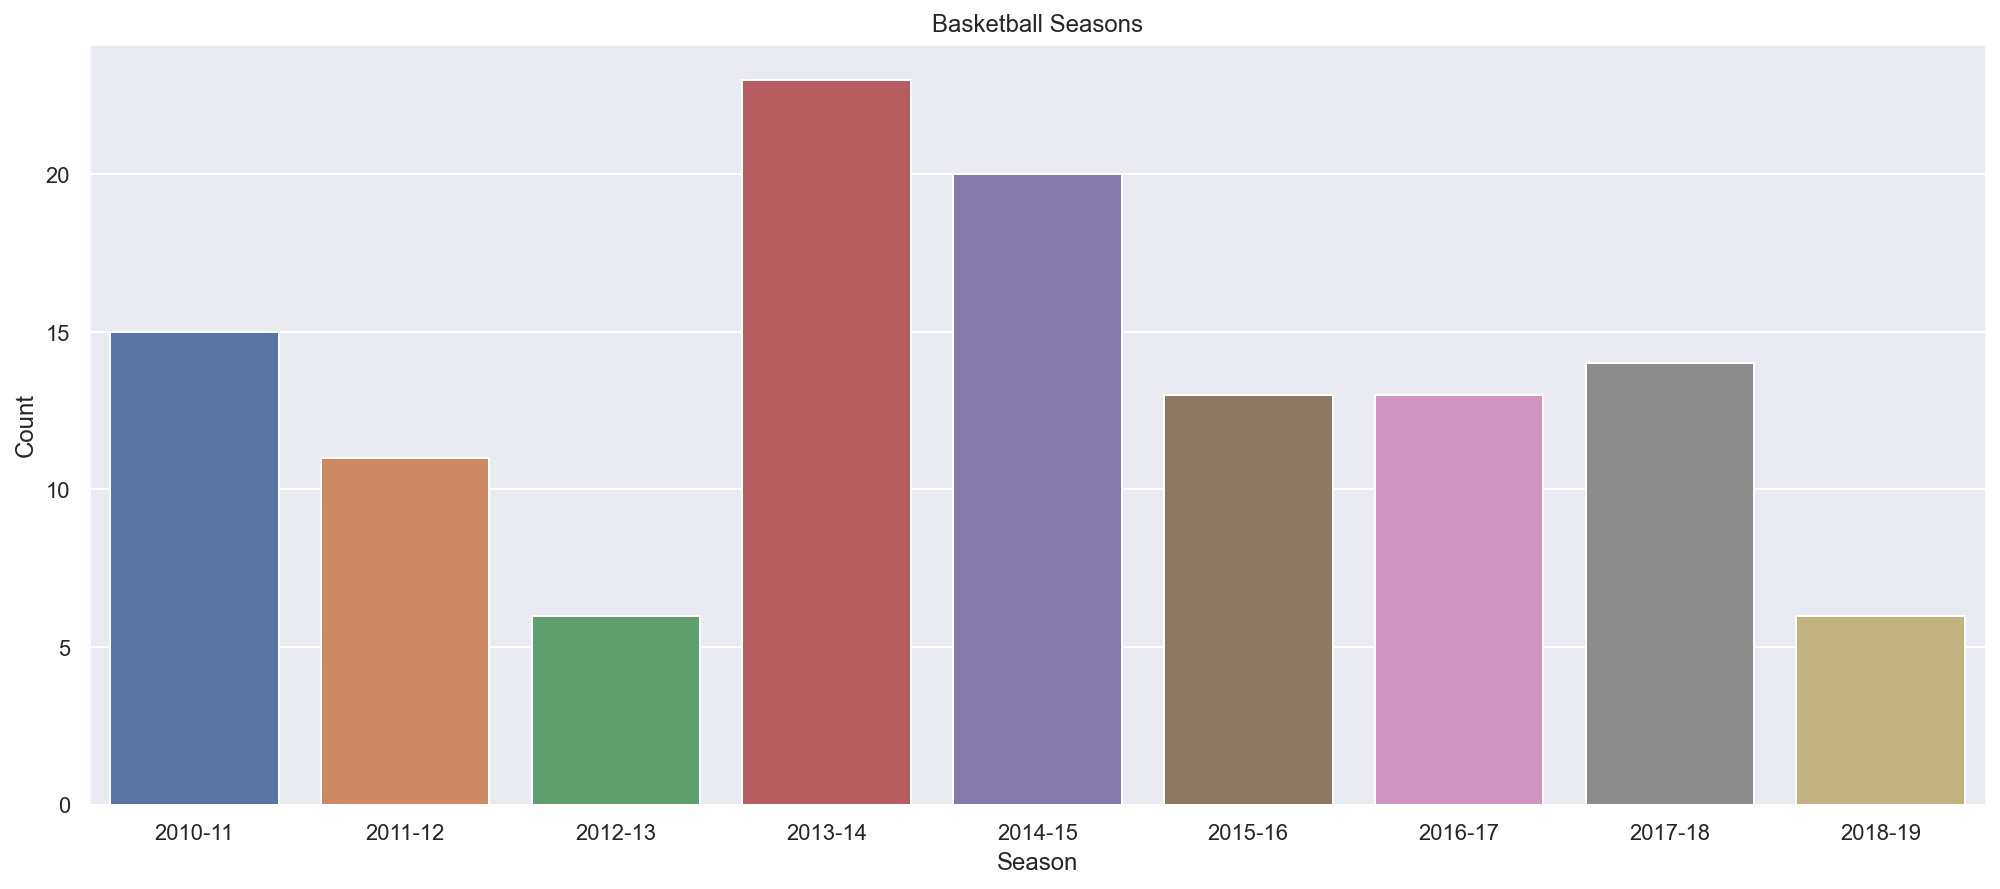

In [15]:
ax = sns.countplot(x = 'Season', data = k3)
ax.set_title('Basketball Seasons');
ax.set_ylabel('Count');
ax.set_xlabel('Season');

This bar chart shows us the total count for Basketball Seasons. This allows for us to see where most of our data comes from. The 2013-2015 season is where most of our players come from. It just so happens that these players played both the season prior and after their injury.

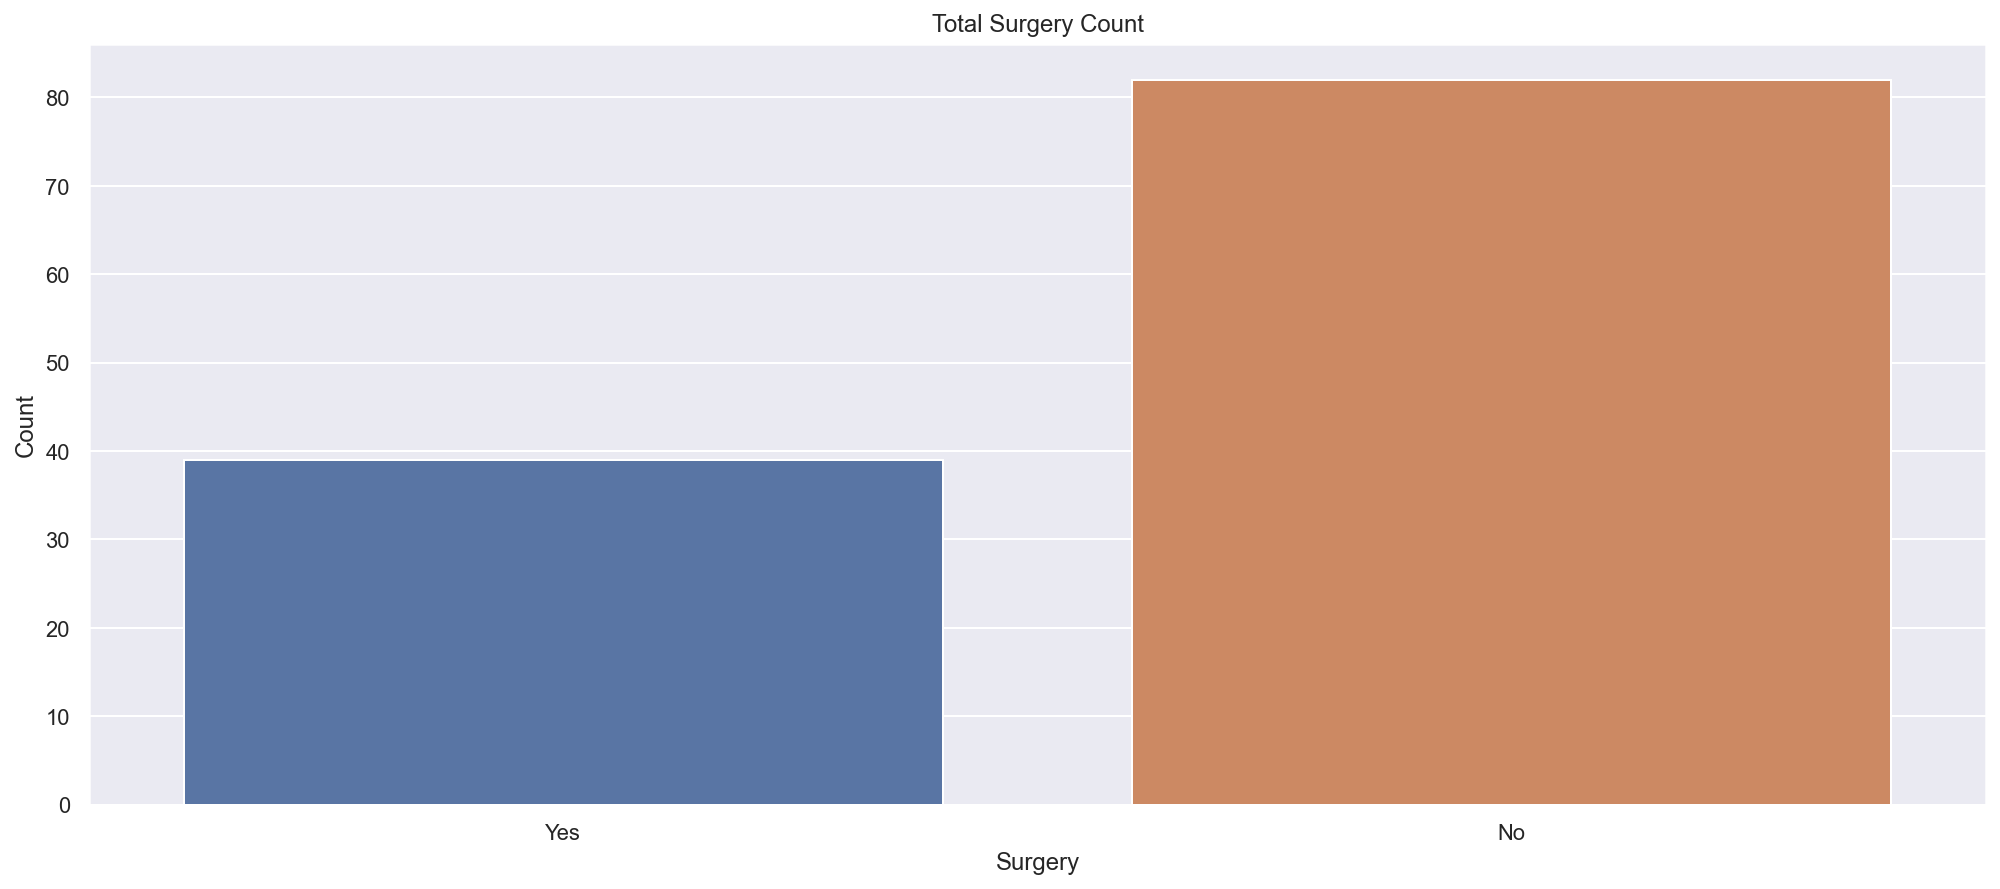

In [16]:
ax = sns.countplot(x = 'Surgery', data = k3)
ax.set_title('Total Surgery Count')
ax.set_ylabel('Count')
ax.set_xlabel('Surgery')
# set tick labels
ax.set_xticklabels(("Yes", "No"));

This bar chart shows us the total surgery count for the total number of players in out data set. The important thing to consider here is that not all of the players had the same injury thus they are not all inclined to have surgery. Although all of their injuries allowed for them to ahve the choice of surgery. Most of our players choose not to have surgery. 

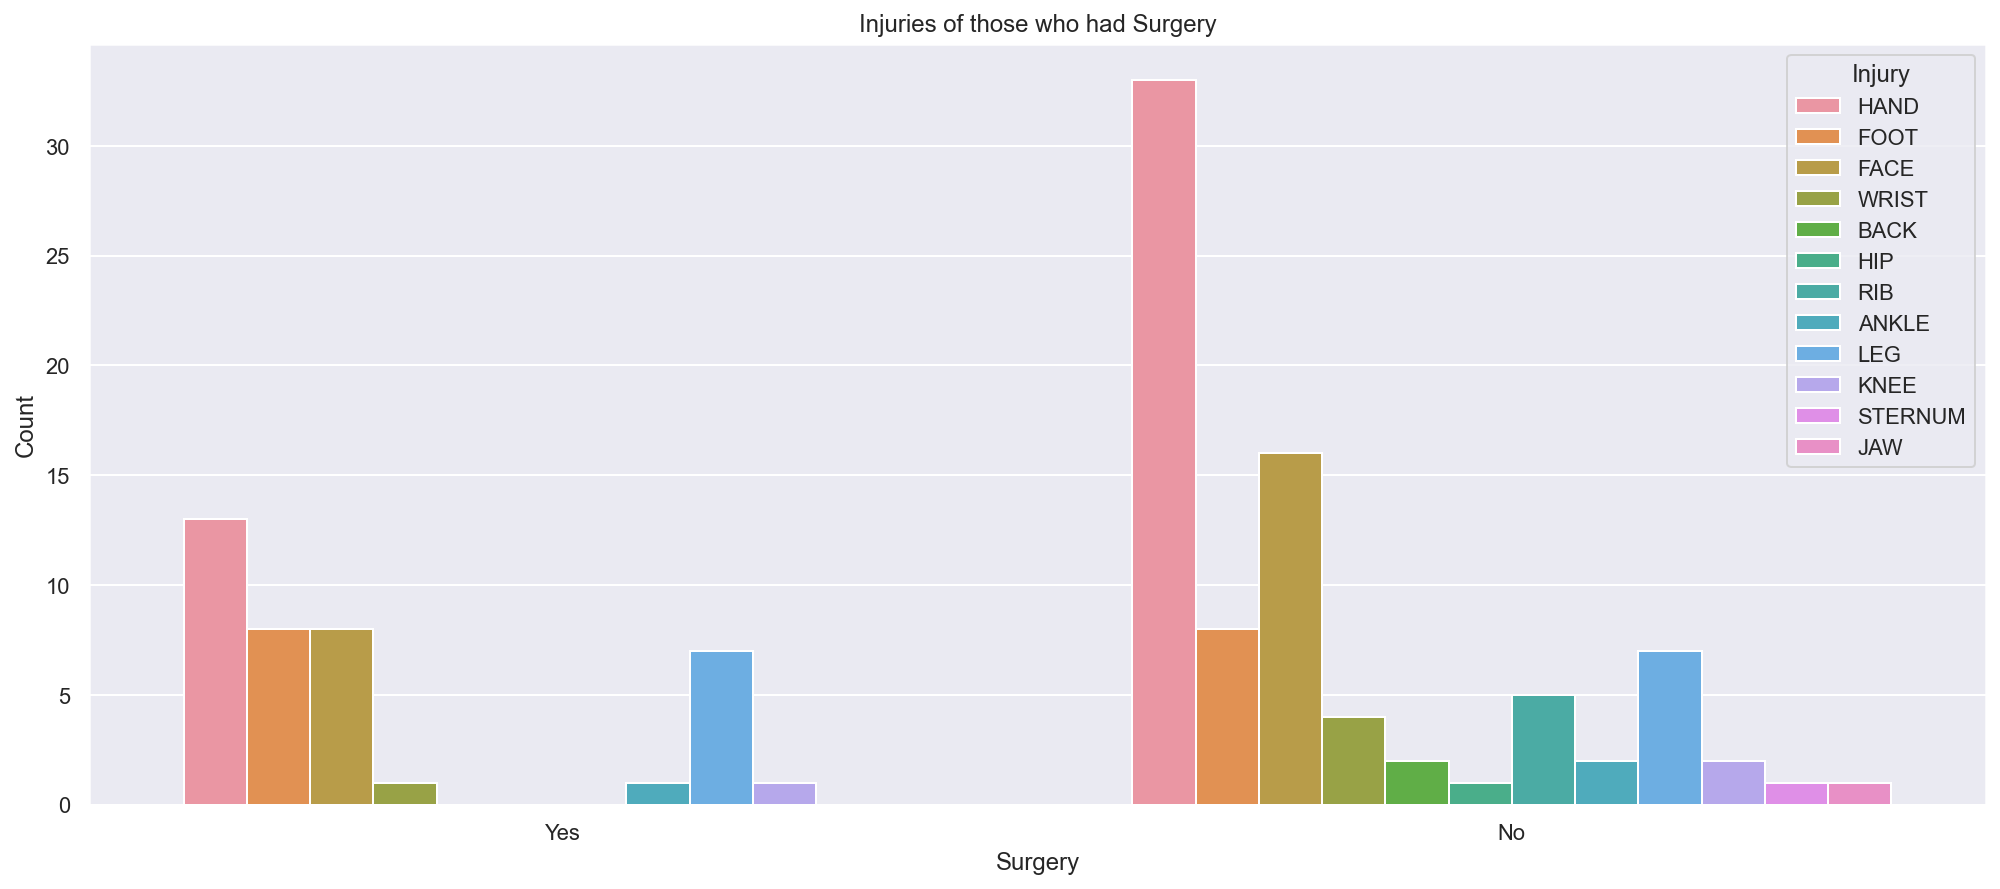

In [17]:
# same color palette as defined earlier
# generate grouped barplot by specifying hue
ax = sns.countplot(x='Surgery', hue='Injury',
                   data=k3)

# add title and axis labels (modify x-axis label)
ax.set_title('Injuries of those who had Surgery')
ax.set_ylabel('Count')
ax.set_xlabel('Surgery')
ax.set_xticklabels(('Yes', 'No'));

This bar chart illustrates the injuries of the players who had surgery based on their specific injury. We can see that the most common injury amongst those who did or didn't have surery was a hand injury. Foot and face injuries both had somewhat similar counts for both having and not having surgery.

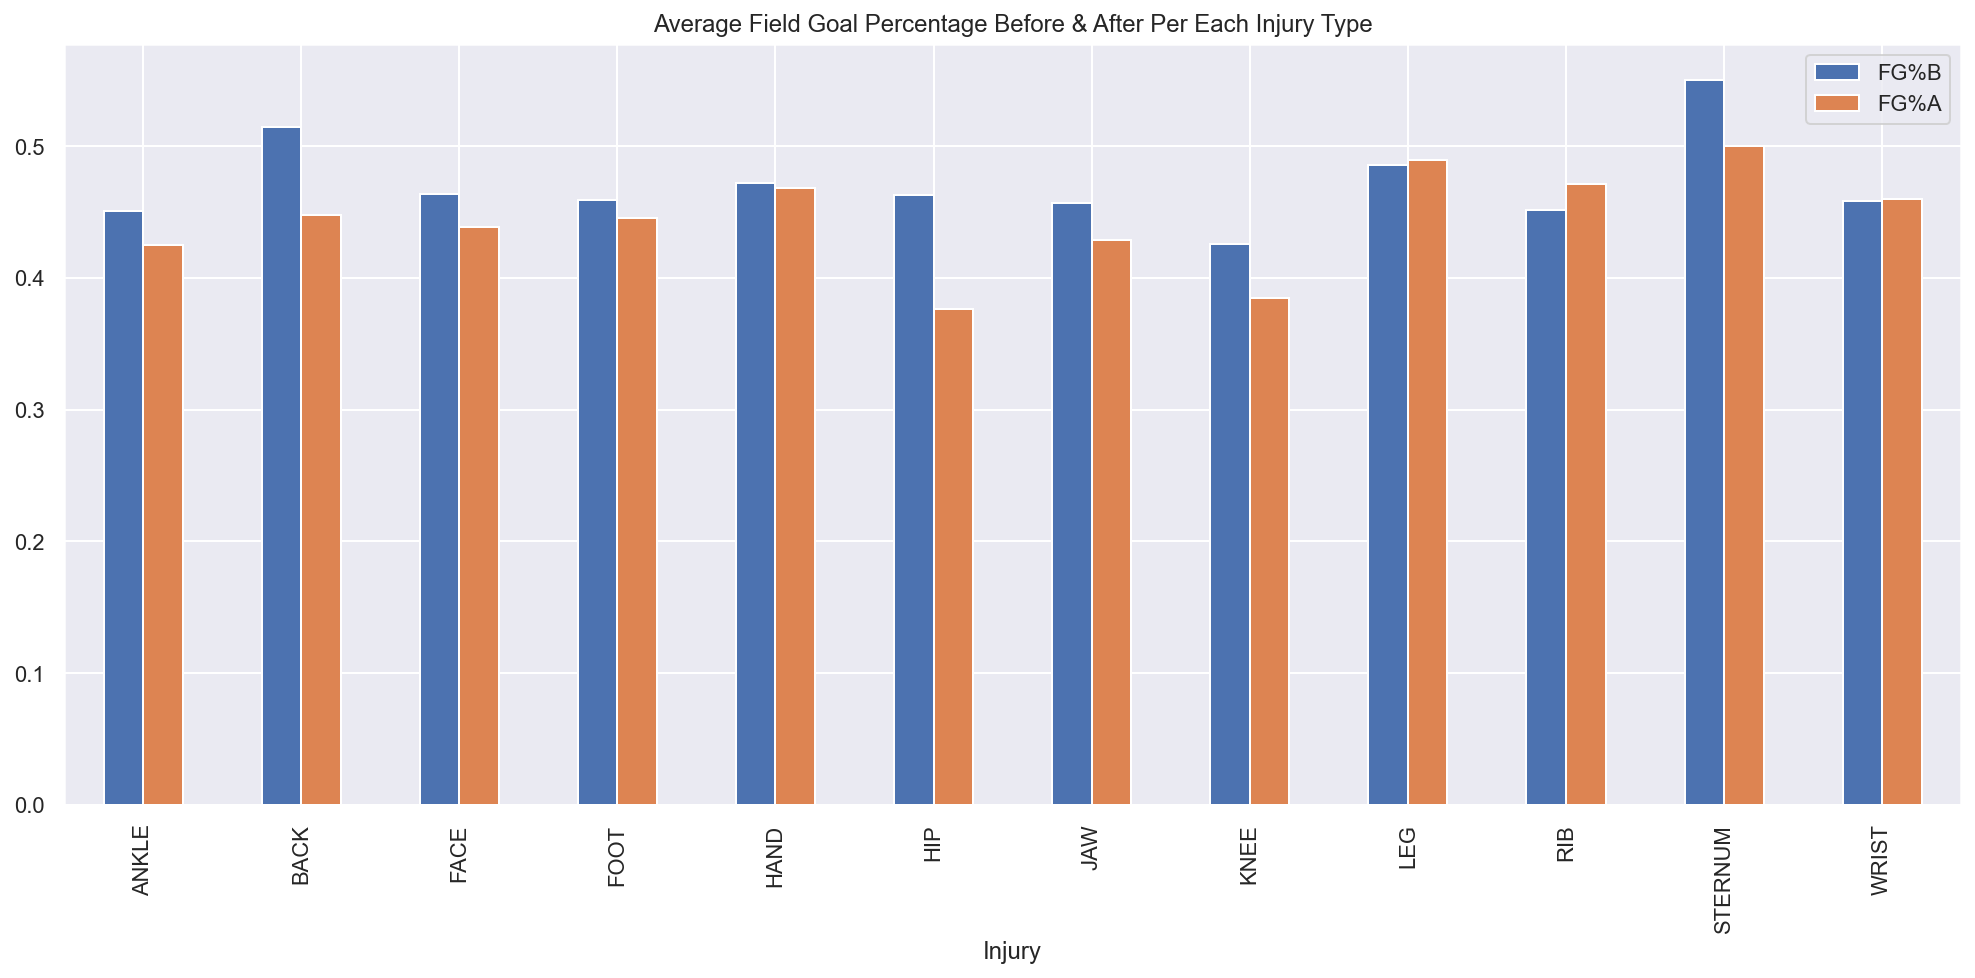

In [18]:
wey = k3.groupby('Injury')['FG%B','FG%A'].mean().plot(kind = 'bar')
wey.set_title('Average Field Goal Percentage Before & After Per Each Injury Type');

This graph displays the average field-goal percentage before (FG%B) and after (FG%A) player injuries. Knowing the average field goal percentage before and after is crucial to knowing how performance changed over time.


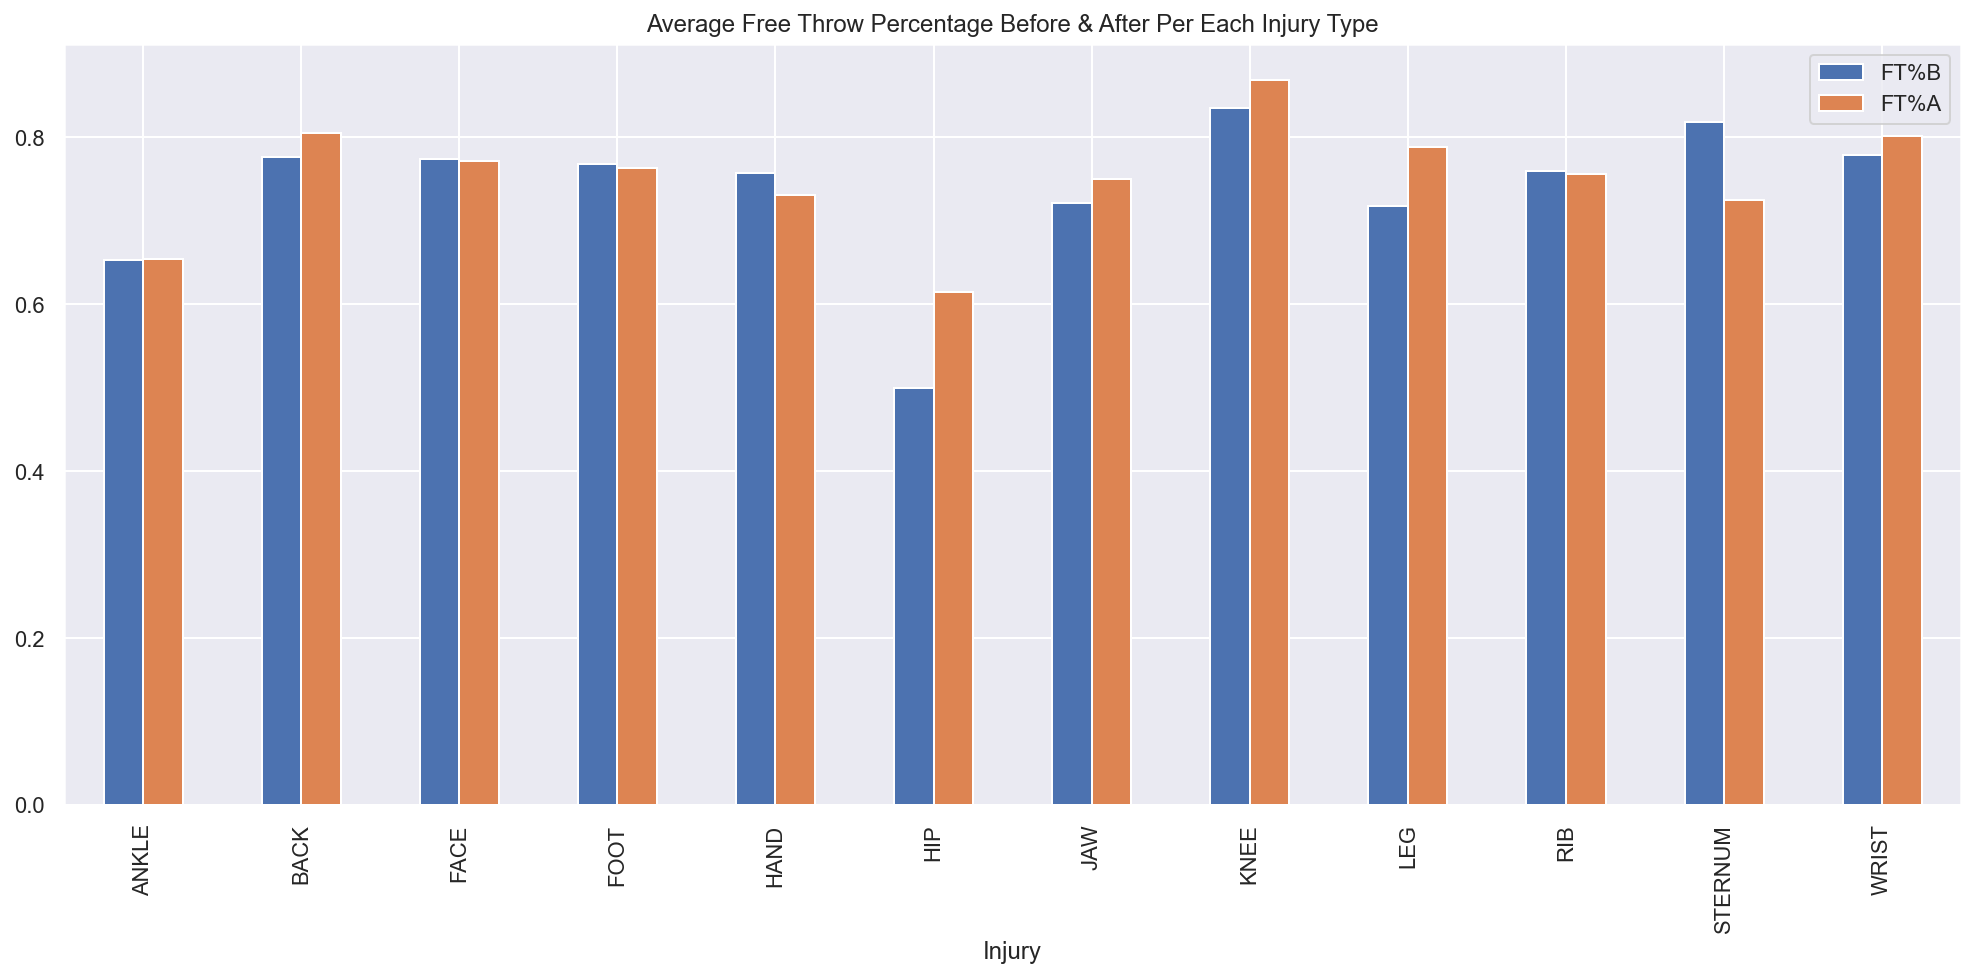

In [19]:
wey2 = k3.groupby('Injury')['FT%B','FT%A'].mean().plot(kind = 'bar')
wey2.set_title('Average Free Throw Percentage Before & After Per Each Injury Type');

The following graphs show the the difference between field goal percentages and free throw percentages before and after treatment depending on injury location 

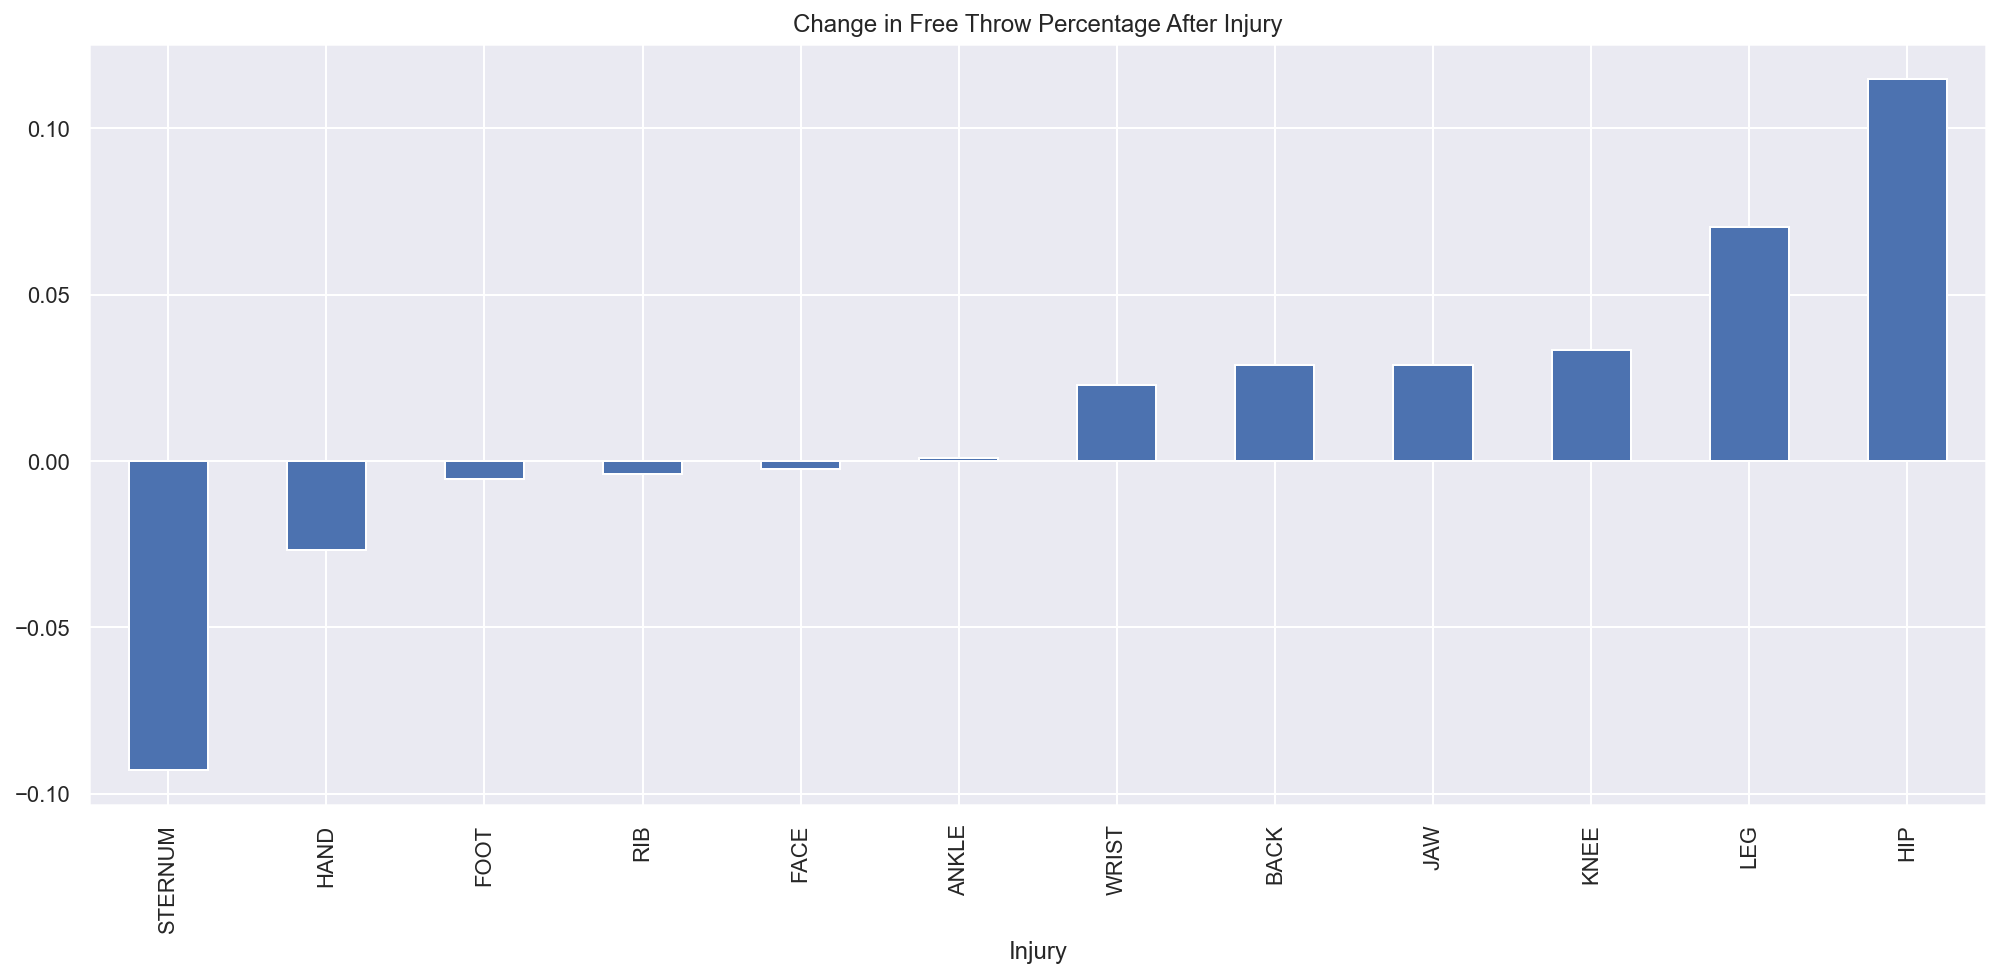

In [20]:
zoom = k3.groupby('Injury')['FT%B','FT%A','FG%B','FG%A'].mean()
zoom['ftdiff']=zoom['FT%A']-zoom['FT%B']
zoom1=zoom['ftdiff'].sort_values().plot(kind='bar')
zoom1.set_title('Change in Free Throw Percentage After Injury');

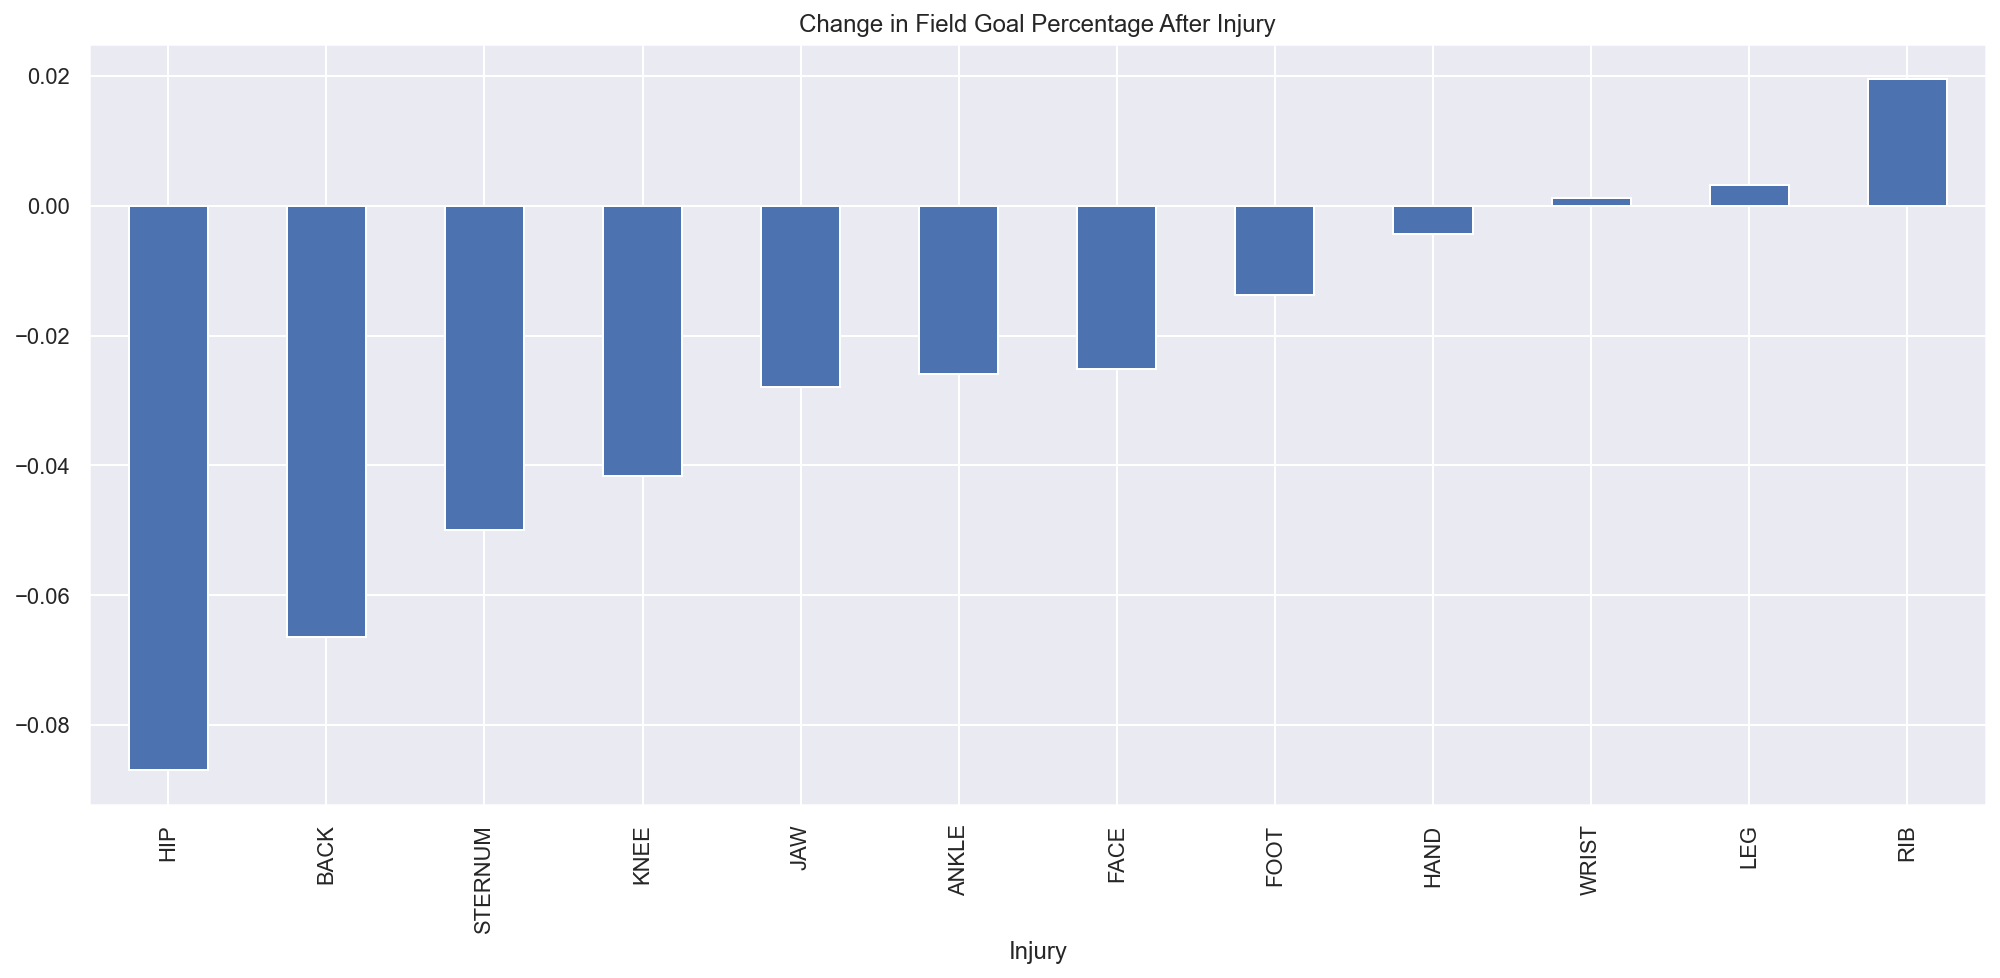

In [21]:
zoom['fgdiff']=zoom['FG%A']-zoom['FG%B']
zoom2=zoom['fgdiff'].sort_values().plot(kind='bar')
zoom2.set_title('Change in Field Goal Percentage After Injury');

we can see that hip and back injuries tend to have the worst recovery rate compared to foor and hand injuries. Wrist, leg and rib injuries interestingly improve output post treatment.

This graph displays the average free-throw percentage before (FT%B) and after (FT%A) player injuries. Knowing the average free-throw percentage before and after is crucial to knowing how performance changed over time.

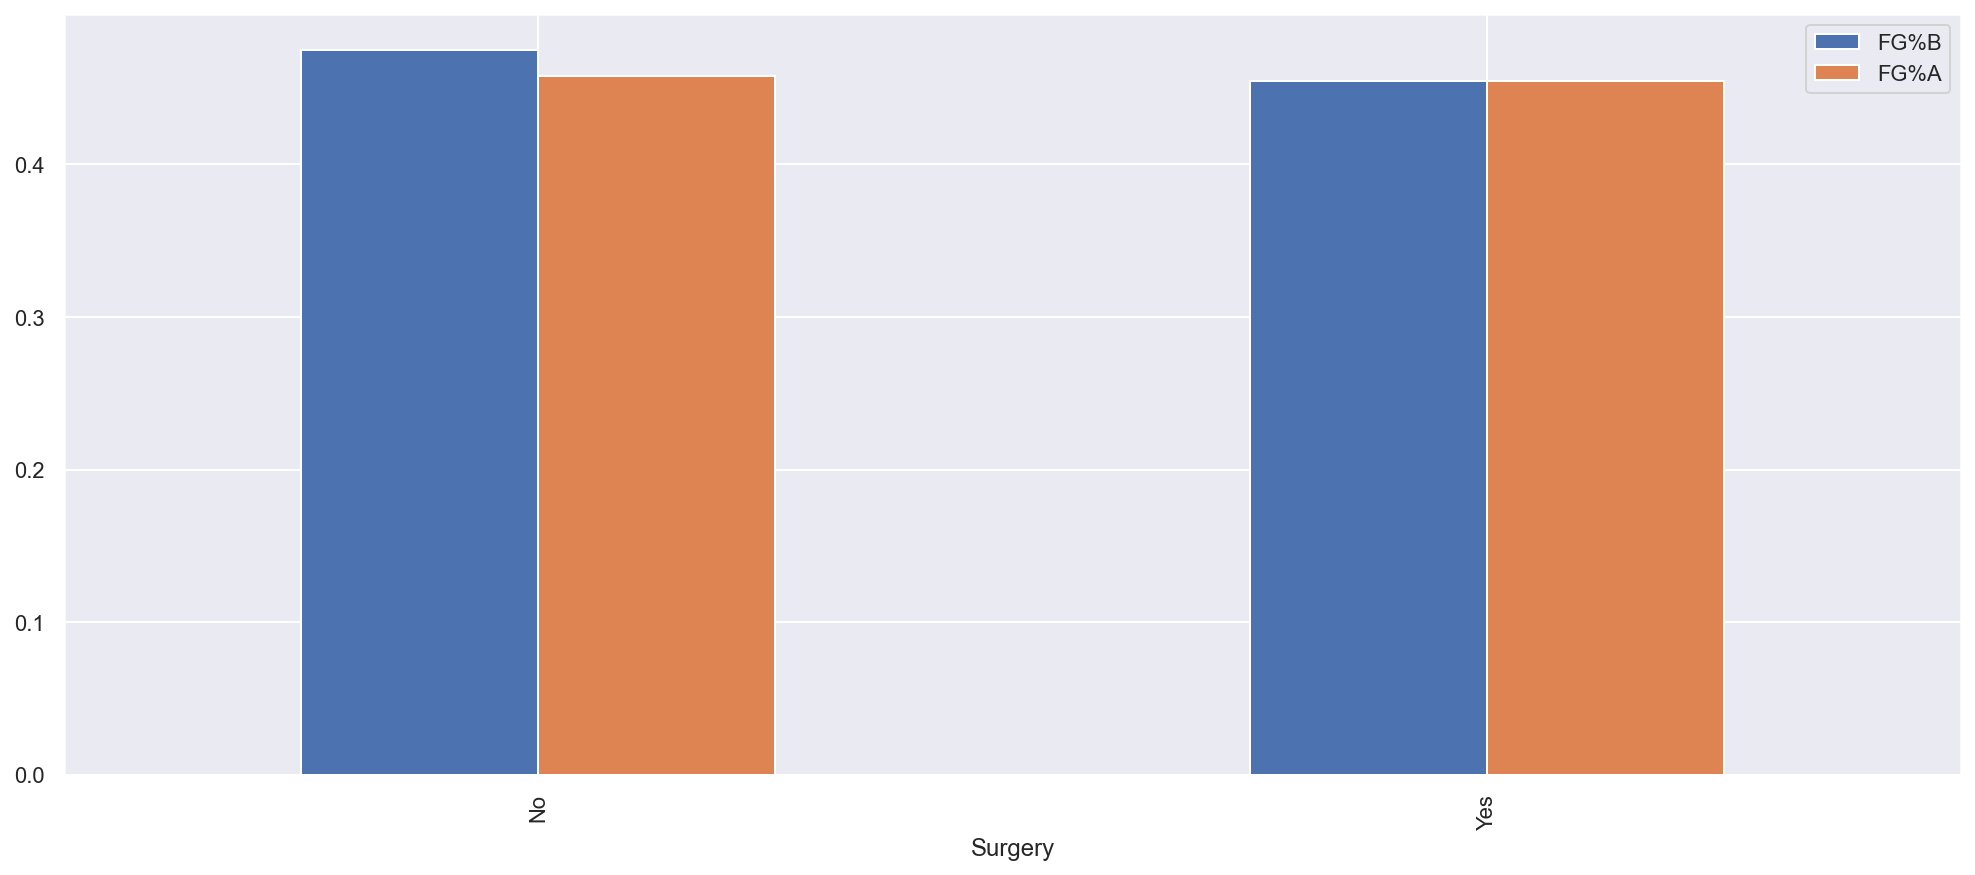

In [22]:
t4=k3.groupby('Surgery')['FG%B','FG%A'].mean().plot(kind = 'bar')
t4.set_xticklabels(("No", "Yes"));

This barplot shows the difference between the averages of field goal percentage before and after treatment depending on the method of treatment. we used this type of plot becasue visualizes the differnece between the means efficiently.

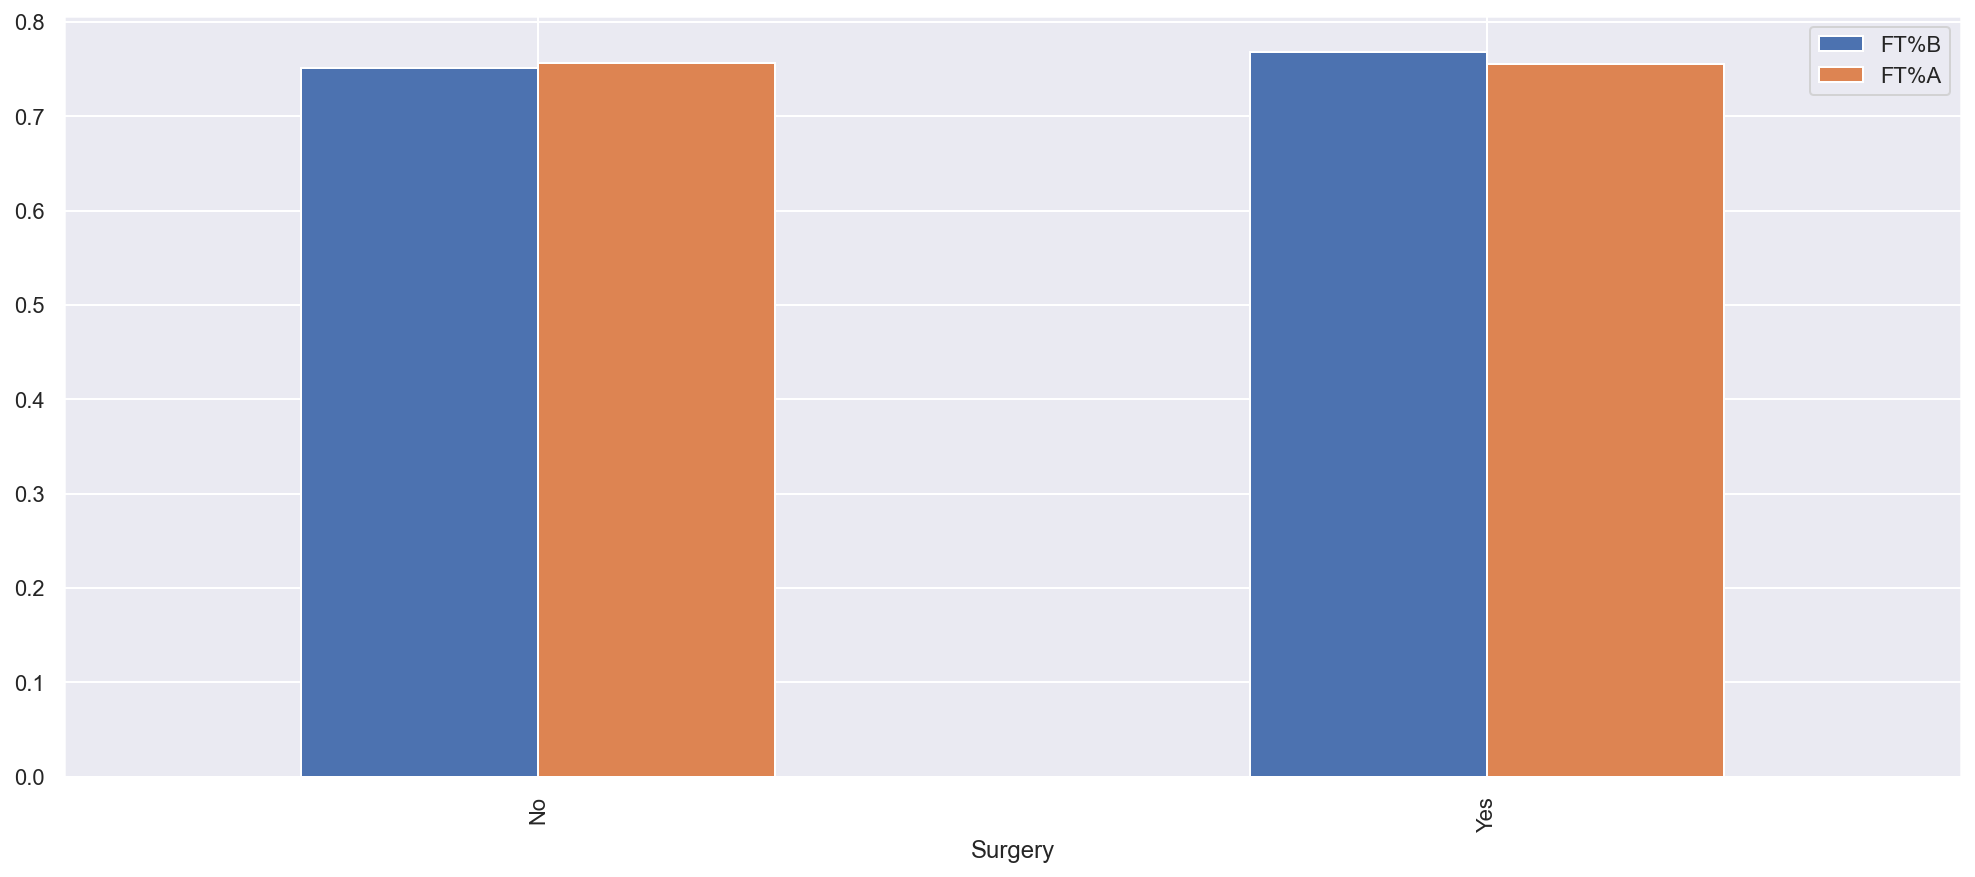

In [23]:
t3=k3.groupby('Surgery')['FT%B','FT%A'].mean().plot(kind = 'bar')
t3.set_xticklabels(("No", "Yes"));

This barplot shows the difference between the averages of free throw goal percentage before and after treatment depending on the method of treatment. similar to the field goal graph, we used this type of plot becasue visualizes the differnece between the means efficiently, we see that most fractures do not require surgery and that this dataset will need more cleaning and sampling in order to get equal numbers between the two test groups.

In the following cells we start our statistical analysis. We used a series of T-tests in order to measure whether our data show any significant statistical difference or not.

In [24]:
t5=k3.groupby('Surgery')['FG%B','FG%A'].mean()
k3['testsfg']=k3['FG%A']-k3['FG%B']
from scipy.stats import ttest_ind
caty=k3['testsfg'][k3['Surgery']=='Y']
catn=k3['testsfg'][k3['Surgery']=='N']
ttest_ind(caty,catn)

Ttest_indResult(statistic=1.6521285752363497, pvalue=0.10114461667746234)

In [25]:
t6=k3.groupby('Surgery')['FT%B','FT%A'].mean()
k3['testsft']=k3['FT%A']-k3['FT%B']
catty=k3['testsft'][k3['Surgery']=='Y']
cattn=k3['testsft'][k3['Surgery']=='N']
ttest_ind(catty,cattn)

Ttest_indResult(statistic=-0.7423795119252831, pvalue=0.4593202932164261)

# Questions to answer about our data
- **Scope:** 2010-2020, injuries and statistics of players in the NBA
- **Faithfullness:** They should be as accurate as possible since basketball statistics tend to be open to the public.
- **Granularity:** The player, their specific injuries, whether they had surgery or not, Average Field Goal Percentage Before and After, Average Free Throw Percentage Before and After
- **Missing Data?:** We didn't have missing data because we specifically choose our data points so that they met certain requirements. These requirements included that a players' injury must allow for an option for surgery. Also these players have had to play the season before and after their surgery date.

We used field goal percentage and free throw percentage because they are one of the most individual based stats in the sense that your teammates and team performance would have less of an effect on the stats and they would give a more accurate description on how they perform as an individual and the effects of injury treatment on said performance.

# Ethics & Privacy

Individual players’ data is open to the public via the different databases. They are free public information. We choose not to censor the names of these individuals because it would produce no harm to these players. If our results are inaccurate or false, there is a high possibility that prospective treatments would be inadequate and ineffective based on the results of this research, for example, if our research falsely concludes that surgery is more effective, we could see an uptick in unnecessary surgeries which would not be beneficial for the injured player which would be a step in the opposite direction from, the purpose of the research, so in order to ensure our results are as valid as possible, we decided to reduce the dataset size in order to reduce the number of confounding factors which are evolved, factors such as type and severity of injury would prove as a confounding variable which would add to the probability of the research to yield inaccurate results. We decided to use Bone Fractures as our Independent variable, because certain bone fractures could be either treated with surgery and conservative, non-invasive surgery.

# Conclusion & Discussion

After further analyzing our results, we concluded that we will fail to reject the null hypothesis. This means that there is no significant statistical difference between invasive and non invasive treatment prognosis as player scores (free throw percentage and field goal percentage) roughly remain the same. Even though there is a slight decrease in field goal percentage after injury in non-invasive treatment, post-invasive treatment production tends to be roughly the same. One issue that our dataset contains is that there is not an equal amount of injury type. If we were to limit the amount of injuries we analyze to have equivalent groups, we would run the risk of having too small of a dataset to be able to have a correct statistical analysis of our data. One other issue with our dataset is that the number of injuries is significantly limited to have a better certainty whether specific injuries have a significant effect on player production. Even though on average surgeries do not have any significant difference in production compared to non-invasive treatment, our data imnplies that area of injury might have an effect on production which would require further research to fully understand said effects.


# Team Contributions

- **Jorge Castaneda:** Creating the webscraper for data aqcuisition
- **David Lopez:** Data visualization and Presentation
- **Mani Amani:**  Data visualization and statistical analysis
- **Francesco Medina:**  Background research and data acquisition